In [1]:
import numpy as np
import math
from sympy import *
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time

In [2]:
def chi2(T):
    p = T[0]; q = T[1]; r = T[2]; s = T[3]; t = T[4]; u = T[5]
    S = 0
    if p+q != 0:
        S += ((p-q)**2)/(p+q)
    if r+s != 0:
        S += ((r-s)**2)/(r+s)
    if t+u != 0:
        S += ((t-u)**2)/(t+u)
    return S

In [3]:
def DOLS_chi2(x,n,m):
    TG = np.zeros((m,6))
    for i in range(m):
        for j in range(n):
            TG[i][int(x[j][i])] += 1
            
    #Step 1
    MCP = np.zeros((m,6)); MCN = np.zeros((m,6)) #MaxChange
    for i in range(m):
        T = TG[i]
        X = chi2(T); MCP[i] = np.zeros(6); MCN[i] = np.zeros(6)
        if T[0] >= 1:
            Y = chi2([T[0]-1, T[1], T[2]+1, T[3], T[4], T[5]])
            MCP[i][0] = max(MCP[i][0], Y-X); MCN[i][0] = max(MCN[i][0], X-Y)
            Y = chi2([T[0]-1, T[1], T[2], T[3], T[4]+1, T[5]])
            MCP[i][0] = max(MCP[i][0], Y-X); MCN[i][0] = max(MCN[i][0], X-Y)
        if T[1] >= 1:
            Y = chi2([T[0], T[1]-1, T[2], T[3]+1, T[4], T[5]])
            MCP[i][1] = max(MCP[i][1], Y-X); MCN[i][1] = max(MCN[i][1], X-Y)
            Y = chi2([T[0], T[1]-1, T[2], T[3], T[4], T[5]+1])
            MCP[i][1] = max(MCP[i][1], Y-X); MCN[i][1] = max(MCN[i][1], X-Y)
        if T[2] >= 1:
            Y = chi2([T[0]+1, T[1], T[2]-1, T[3], T[4], T[5]])
            MCP[i][2] = max(MCP[i][2], Y-X); MCN[i][2] = max(MCN[i][2], X-Y)
            Y = chi2([T[0], T[1], T[2]-1, T[3], T[4]+1, T[5]])
            MCP[i][2] = max(MCP[i][2], Y-X); MCN[i][2] = max(MCN[i][2], X-Y)
        if T[3] >= 1:
            Y = chi2([T[0], T[1]+1, T[2], T[3]-1, T[4], T[5]])
            MCP[i][3] = max(MCP[i][3], Y-X); MCN[i][3] = max(MCN[i][3], X-Y)
            Y = chi2([T[0], T[1], T[2], T[3]-1, T[4], T[5]+1])
            MCP[i][3] = max(MCP[i][3], Y-X); MCN[i][3] = max(MCN[i][3], X-Y)
        if T[4] >= 1:
            Y = chi2([T[0]+1, T[1], T[2], T[3], T[4]-1, T[5]])
            MCP[i][4] = max(MCP[i][4], Y-X); MCN[i][4] = max(MCN[i][4], X-Y)
            Y = chi2([T[0], T[1], T[2]+1, T[3], T[4]-1, T[5]])
            MCP[i][4] = max(MCP[i][4], Y-X); MCN[i][4] = max(MCN[i][4], X-Y)
        if T[5] >= 1:
            Y = chi2([T[0], T[1]+1, T[2], T[3], T[4], T[5]-1])
            MCP[i][5] = max(MCP[i][5], Y-X); MCN[i][5] = max(MCN[i][5], X-Y)
            Y = chi2([T[0], T[1], T[2], T[3]+1, T[4], T[5]-1])
            MCP[i][5] = max(MCP[i][5], Y-X); MCN[i][5] = max(MCN[i][5], X-Y)
    
    #Step 2
    LSS = np.zeros(int(2**m))
    for j in range(n):
        LSJ = np.zeros((m,int(2**m)))
        LSJ[0][0] = MCP[0][int(x[j][0])]; LSJ[0][1] = MCN[0][int(x[j][0])]
        #print(LSJ[0],LSJ[1])
        for i in range(1,m):
            for k in range(2**i):
                LSJ[i][2*k+0] = LSJ[i-1][k] + MCP[i][int(x[j][i])]
                LSJ[i][2*k+1] = LSJ[i-1][k] + MCN[i][int(x[j][i])]
        #print(LSJ)
        for i in range(int(2**m)):
            LSS[i] = max(LSS[i],LSJ[m-1][i])    
        #print(LSS)
        
    #Step 3
    DOLSP = np.zeros(m) #LS^{i+}
    DOLSN = np.zeros(m) #LS^{i-}
    
    for j in range(m):
        for i in range(int(2**m)):
            if int(i/(2**(m-1-j)))%2 == 0:
                DOLSP[j] = max(DOLSP[j], LSS[i])
            else:
                DOLSN[j] = max(DOLSN[j], LSS[i])
    
    return DOLSP, DOLSN

In [4]:
def h3(z,l):
    return (3*np.sqrt(3)*(l**(2/3)))/(4*math.pi*(math.fabs(z)**3+l))

def cdf(x,h,l):
    g = lambda z: h(z,l)
    return integrate.quad(g,-oo,x)

def noise(h,l,d): # using inverse transform sampling
    r = np.random.rand()
    q = 1000; z = 10
    for i in range(-50,50):
        if math.fabs(r - cdf(i/5,h,l)[0]) > q:
            z = (i-1)/5
            break
        else:
            q = min(q, math.fabs(r - cdf(i/5,h,l)[0]))
    if d == 0:
        return math.fabs(z)
    elif d == 1:
        return -math.fabs(z)
    
def alpha(k,l,m,ei): #epsilon = ei*m
    return ((l**(1/k))*(ei*m))/(2*((k-1)**((k-1)/k)))

In [5]:
def DOSS_chi2_test_positive(n,m):
    x = np.ones((n,m))
    for j in range(m):
        for i in range(int(n/2)):
            if i < 1:
                x[i][j] = 0
            else:
                x[i][j] = 4
        for i in range(int(n/2)):
            if i < 1:
                x[i+int(n/2)][j] = 1
            else:
                x[i+int(n/2)][j] = 3
    DOLSP, DOLSN = DOLS_chi2(x,n,m)
    #LS = max(max(DOLSP), max(DOLSN))
    #print(LS/min(DOLSP), LS/min(DOLSN))
    return DOLSP, DOLSN

def DOSS_chi2_test_negative(n,m):
    x = np.ones((n,m))
    for j in range(m):
        for i in range(int(n/2)):
            if i < 1:
                x[i][j] = 0
            elif i < int((n-2)/4):
                x[i][j] = 2
            else:
                x[i][j] = 4
        for i in range(int(n/2)):
            if i < 1:
                x[i+int(n/2)][j] = 1
            elif i < int((n+2)/4):
                x[i+int(n/2)][j] = 3
            else:
                x[i+int(n/2)][j] = 5
    DOLSP, DOLSN = DOLS_chi2(x,n,m)
    #LS = max(max(DOLSP), max(DOLSN))
    #print(LS/min(DOLSP), LS/min(DOLSN))
    return DOLSP, DOLSN

In [6]:
def accuracy_positive(n,m,DOLSP,DOLSN):
    acc = np.zeros((8,2))
    k = 3; l = 3
    LS = np.zeros(20)
    ei = [15+5*i for i in range(8)]
    
    for j in range(20):
        LS[j] = max(max(DOLSP[j]), max(DOLSN[j]))
        for i in range(8):
            for t in range(m):
                if random.random()<0.5:
                    z = noise(h3,l,0)
                    acc[i][0] += math.fabs((DOLSP[j][t]/alpha(k,l,m,ei[i]))*z)
                    acc[i][1] += math.fabs((LS[j]/alpha(k,l,m,ei[i]))*z)
    return acc/(m*20)

def accuracy_negative(n,m,DOLSP,DOLSN):
    acc = np.zeros((8,2))
    k = 3; l = 3
    LS = np.zeros(20)
    ei = [15+5*i for i in range(8)]
    
    for j in range(20):
        LS[j] = max(max(DOLSP[j]), max(DOLSN[j]))
        for i in range(8):
            for t in range(m):
                if random.random()<0.5:
                    z = noise(h3,l,1)
                    acc[i][0] += math.fabs((DOLSN[j][t]/alpha(k,l,m,ei[i]))*z)
                    acc[i][1] += math.fabs((LS[j]/alpha(k,l,m,ei[i]))*z)
    return acc/(m*20)

[[0.12914204 0.2548403 ]
 [0.20471949 0.40397979]
 [0.11094476 0.21893098]
 [0.15849251 0.31275855]
 [0.16855552 0.33261623]
 [0.03962313 0.07818964]
 [0.08707304 0.17182414]
 [0.08364882 0.16506701]]
[[0.15262242 0.3011749 ]
 [0.09245396 0.18244249]
 [0.19547409 0.38573554]
 [0.02641542 0.05212642]
 [0.11698257 0.2308456 ]
 [0.05613276 0.11076865]
 [0.12914204 0.2548403 ]
 [0.04050364 0.07992718]]
[[0.30817988 0.60814162]
 [0.10566167 0.2085057 ]
 [0.1074227  0.21198079]
 [0.21132334 0.4170114 ]
 [0.12452983 0.24573886]
 [0.03411991 0.06732997]
 [0.0381556  0.07529372]
 [0.06163598 0.12162832]]
[[0.09392149 0.1853384 ]
 [0.13647966 0.26931986]
 [0.11622784 0.22935627]
 [0.13060957 0.25773621]
 [0.0603781  0.11914611]
 [0.08695075 0.17158282]
 [0.042069   0.08301616]
 [0.06515803 0.12857851]]
[[0.27002427 0.5328479 ]
 [0.1739015  0.34316563]
 [0.07396317 0.14595399]
 [0.09538901 0.18823431]
 [0.09182502 0.18120138]
 [0.08364882 0.16506701]
 [0.04989579 0.09846102]
 [0.07044111 0.139003

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


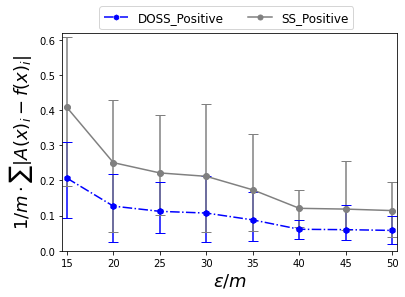

In [7]:
n = 150; m = 1

acc = np.zeros((8,2))
max_acc = np.zeros((8,2)); min_acc = np.ones((8,2))
sum_acc = np.zeros((8,2))

DOLSP = np.zeros((20,m)); DOLSN = np.zeros((20,m))
for i in range(20):
    DOLSP[i], DOLSN[i] = DOSS_chi2_test_positive(n,m)

jj = 10
for j in range(jj):
    acc = accuracy_positive(n,m,DOLSP,DOLSN)
    for i in range(8):
        for k in range(2):
            max_acc[i][k] = max(max_acc[i][k], acc[i][k])
            min_acc[i][k] = min(min_acc[i][k], acc[i][k])
            sum_acc[i][k] += acc[i][k]
    print(acc)
acc = sum_acc/jj

y_err = np.zeros((2,8,2))
for k in range(2):
    y_err[0,:,k] = acc[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - acc[:,k]

ei = [15+5*i for i in range(8)]

print(acc)
fig = plt.figure()
plt.ylim(0, max(max_acc[i][j] for i in range(6) for j in range(2))+0.01)
plt.xlim(14.5, 50.5)
plt.errorbar(ei, acc[:,0], yerr = y_err[:,:,0], capsize=5, fmt='h', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(ei, acc[:,0], marker="h", markersize=5, color = "blue", linestyle = "dashdot", label = "DOSS_Positive")
plt.errorbar(ei, acc[:,1], yerr = y_err[:,:,1], capsize=5, fmt='o', ecolor='gray', markeredgecolor = "gray", color='gray')
plt.plot(ei, acc[:,1], marker="o", markersize=5, color = "gray", linestyle = "-", label = "SS_Positive")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=2, fontsize=12)
plt.xlabel("$\epsilon/m$", fontsize = 18)
plt.ylabel("$1/m \cdot \sum |A(x)_i - f(x)_i|$", fontsize = 18)
fig.savefig("Accuracy_chi2_positive_m=1.png")
fig.savefig("figs/Accuracy_chi2_positive_m=1.eps", bbox_inches="tight", pad_inches=0.05)

[[0.00257855 0.09923847]
 [0.00300501 0.11565099]
 [0.00076166 0.02931352]
 [0.00087274 0.03358841]
 [0.0011731  0.04514805]
 [0.00074381 0.02862648]
 [0.00050249 0.01933878]
 [0.00107109 0.04122214]]
[[0.00614886 0.23664559]
 [0.00223144 0.08587945]
 [0.00183276 0.07053565]
 [0.00083307 0.03206166]
 [0.00188716 0.07262948]
 [0.00102646 0.03950455]
 [0.00132233 0.05089152]
 [0.00058315 0.02244316]]
[[0.00190416 0.0732838 ]
 [0.0018149  0.06984862]
 [0.00123771 0.04763447]
 [0.00138845 0.0534361 ]
 [0.00073106 0.02813574]
 [0.00077357 0.02977154]
 [0.0010182  0.03918647]
 [0.00086877 0.03343573]]
[[0.00154713 0.05954308]
 [0.00154713 0.05954308]
 [0.0011663  0.04488632]
 [0.00095208 0.0366419 ]
 [0.00141112 0.05430853]
 [0.00133886 0.05152767]
 [0.00111076 0.04274888]
 [0.00108299 0.04168016]]
[[0.00325294 0.12519315]
 [0.00235045 0.09045969]
 [0.00171375 0.06595542]
 [0.00103142 0.03969539]
 [0.00093508 0.03598758]
 [0.00043141 0.01660336]
 [0.00104464 0.0402043 ]
 [0.00052364 0.020153

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.00483974 0.18626298]
 [0.00214218 0.08244427]
 [0.00059505 0.02290119]
 [0.00142812 0.05496285]
 [0.00044204 0.01701231]
 [0.00068431 0.02633636]
 [0.0011901  0.04580237]
 [0.00049984 0.019237  ]]
[[0.00284831 0.10962034]
 [0.0020321  0.07820755]
 [0.00149953 0.05771099]
 [0.0011663  0.04488632]
 [0.00108299 0.04168016]
 [0.00096696 0.03721443]
 [0.00093754 0.03608209]
 [0.00075095 0.0289013 ]]


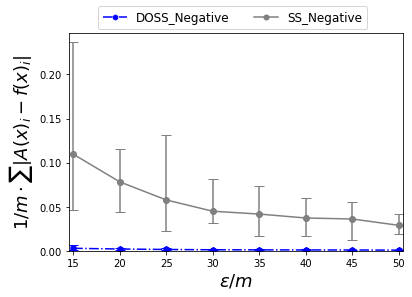

In [8]:
n = 150; m = 1

acc = np.zeros((8,2))
max_acc = np.zeros((8,2)); min_acc = np.ones((8,2))
sum_acc = np.zeros((8,2))

DOLSP = np.zeros((20,m)); DOLSN = np.zeros((20,m))
for i in range(20):
    DOLSP[i], DOLSN[i] = DOSS_chi2_test_negative(n,m)

jj = 10
for j in range(jj):
    acc = accuracy_negative(n,m,DOLSP,DOLSN)
    for i in range(8):
        for k in range(2):
            max_acc[i][k] = max(max_acc[i][k], acc[i][k])
            min_acc[i][k] = min(min_acc[i][k], acc[i][k])
            sum_acc[i][k] += acc[i][k]
    print(acc)
acc = sum_acc/jj

y_err = np.zeros((2,8,2))
for k in range(2):
    y_err[0,:,k] = acc[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - acc[:,k]

ei = [15+5*i for i in range(8)]

print(acc)
fig = plt.figure()
plt.ylim(0, max(max_acc[i][j] for i in range(6) for j in range(2))+0.01)
plt.xlim(14.5, 50.5)
plt.errorbar(ei, acc[:,0], yerr = y_err[:,:,0], capsize=5, fmt='h', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(ei, acc[:,0], marker="h", markersize=5, color = "blue", linestyle = "dashdot", label = "DOSS_Negative")
plt.errorbar(ei, acc[:,1], yerr = y_err[:,:,1], capsize=5, fmt='o', ecolor='gray', markeredgecolor = "gray", color='gray')
plt.plot(ei, acc[:,1], marker="o", markersize=5, color = "gray", linestyle = "-", label = "SS_Negative")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=2, fontsize=12)
plt.xlabel("$\epsilon/m$", fontsize = 18)
plt.ylabel("$1/m \cdot \sum |A(x)_i - f(x)_i|$", fontsize = 18)
fig.savefig("Accuracy_chi2_negative_m=1.png")
fig.savefig("figs/Accuracy_chi2_negative_m=1.eps", bbox_inches="tight", pad_inches=0.05)